<h1><b>hierarchical model Implementation to Classify Image as Normal Or Abnormal and If Abnormal then It further Classify the Image into Four 
Subclasses</b></h1>
<h4>Tuberculosis</h4>
<h4>Corona Virus Disease</h4>
<h4>Bacterial Pneumonia</h4>
<h4>Viral Pneumonia</h4>

In [4]:
'''
Importing All the Necessory Libraries and Packages
'''
# %%capture
# !pip install pillow imgaug
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow import keras
import os
# from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil
# import imgaug.augmenters as iaa

In [2]:
'''
Copy Dataset From Input Directory To Working Directory
'''
source_dir = '/kaggle/input/lungs-disease-dataset-4-types'
destination_dir = '/kaggle/working/Dataset'

os.makedirs(destination_dir, exist_ok=True)

for folder in os.listdir(source_dir):
    src_folder = os.path.join(source_dir, folder)
    dest_folder = os.path.join(destination_dir, folder)
    
    if os.path.isdir(src_folder):
        shutil.copytree(src_folder, dest_folder)

<h1>Data Preprocessing</h1>

In [3]:
import os
import shutil

base_dir = '/kaggle/working/Dataset/Lung Disease Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

for class_name in os.listdir(val_dir):
    val_class_path = os.path.join(val_dir, class_name)
    train_class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(val_class_path) and os.path.isdir(train_class_path):
        for image_name in os.listdir(val_class_path):
            src = os.path.join(val_class_path, image_name)
            dst = os.path.join(train_class_path, image_name)
            shutil.move(src, dst)

In [4]:
shutil.rmtree('/kaggle/working/Dataset/Lung Disease Dataset/val')

In [5]:
new_train_dir = os.path.join(base_dir, 'hub')
train_dir = os.path.join(base_dir, 'train')
base_dir = 'path/to/your/kaggle/working/directory'

os.rename(train_dir, new_train_dir)

<h1>Generating More Samples From Existing Samples Using Data Augmentation </h1>

In [7]:
# Define the folder containing your subfolders
dataset_folder = '/kaggle/working/Dataset/Lung Disease Dataset/hub'
output_count_per_class = 1500

# Define augmentation sequence
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Affine(rotate=(-20, 20)),  # Rotate images
    iaa.AdditiveGaussianNoise(scale=(10, 30)),  # Add noise
    iaa.Multiply((0.8, 1.2)),  # Change brightness
    iaa.LinearContrast((0.8, 1.2)),  # Adjust contrast
    iaa.Crop(percent=(0, 0.1)),  # Randomly crop images
])

# Process each subfolder
for subfolder in os.listdir(dataset_folder):
    subfolder_path = os.path.join(dataset_folder, subfolder)

    if os.path.isdir(subfolder_path):
        # Load images from the subfolder
        images = [os.path.join(subfolder_path, img) for img in os.listdir(subfolder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

        # Generate augmented images
        count = 1
        while count <= output_count_per_class:
            for img_path in images:
                img = Image.open(img_path)
                img = img.convert('RGB')  # Ensure image is in RGB format
                img_np = np.array(img)

                # Apply augmentation
                augmented_images = seq(images=[img_np] * 5)  # Create 5 augmented versions of the image

                for augmented_img in augmented_images:
                    # Save the augmented images
                    new_filename = f"{subfolder}_{count}.jpg"
                    new_filepath = os.path.join(subfolder_path, new_filename)
                    Image.fromarray(augmented_img).save(new_filepath)
                    count += 1

                    if count > output_count_per_class:
                        break
                if count > output_count_per_class:
                    break


In [8]:
'''
Updating Folder Architecture For Herarichal Model
'''

# Define base directory and hub path
base_dir = '/kaggle/working/Dataset/Lung Disease Dataset'
hub_dir = os.path.join(base_dir, 'hub')
abnormal_dir = os.path.join(hub_dir, 'Abnormal')

# Define the classes to move
classes_to_move = [i for i in os.listdir('/kaggle/working/Dataset/Lung Disease Dataset/hub') if i!='Normal']

# Create the Abnormal directory
os.makedirs(abnormal_dir, exist_ok=True)

# Move the specified folders into the Abnormal directory
for class_name in classes_to_move:
    class_path = os.path.join(hub_dir, class_name)
    if os.path.exists(class_path):
        shutil.move(class_path, abnormal_dir)

print("Folders moved successfully. Structure updated.")


Folders moved successfully. Structure updated.


<h1>Main Class Containing All the Functionality</h1>

In [6]:
class Main:
    def __init__(self,Dataset_Path,img_height,img_width,num_subclasses,input_shape):
        '''
        Main Class Where all the functionality Of Code is Present
        '''

        self.Dataset_Path=Dataset_Path
        self.normal_path=os.path.join(self.Dataset_Path,'Normal')
        self.Abnormal_path=os.path.join(self.Dataset_Path,'Abnormal')
        self.img_height=img_height
        self.img_width = img_width  # Image dimensions
        self.num_subclasses = num_subclasses  # Number of subclasses for abnormal images
        self.input_shape=input_shape
    
    def Visualize_Dataset_Distribution(self):
        '''
        This Function WIll Plot all the Dataset Distribution and Samples
        '''
        Size_Of_Normal=len(os.listdir(self.normal_path))
        Size_Of_Abnormal=[]
        Names=[]
        for Sub_CLass in os.listdir(self.Abnormal_path):
            Sub_Class_Path=os.path.join(self.Abnormal_path,Sub_CLass)
            Size_Of_Abnormal.append(len(os.listdir(Sub_Class_Path)))
            Names.append(Sub_CLass)

        Size_Of_Abnormal_Subfolder=sum(Size_Of_Abnormal)
        Over_ALL_Dataset=sum([Size_Of_Abnormal_Subfolder,Size_Of_Normal])

        '''
        Plotting Dataset Distribution
        '''
        plt.figure(figsize=(12,4))
        plt.title("Dataset_Distribution")
        plt.bar(["TotalImages","AbnormalImages","NormalImages"],[Over_ALL_Dataset,Size_Of_Abnormal_Subfolder,Size_Of_Normal],color="skyblue")
        plt.show()
        plt.tight_layout()

        '''
        Plotting Abnormal CLasses Distribution
        '''
        plt.figure(figsize=(12,4))
        plt.title("Abnormal Class Dataset_Distribution")
        plt.bar(Names,Size_Of_Abnormal,color=['red','blue'])
        plt.show()
        plt.tight_layout()



    def Plot_Samples(self):
        '''
        This Function will plot some of the Samples
        '''

        ##Extracting Images Path
        Images_Path=[]
        for images in os.listdir(self.normal_path):
            Path=os.path.join(self.normal_path,images)
            Images_Path.append(Path)
        Images_Path=Images_Path[:5]

        ##plot normal images
        fig, axes = plt.subplots(1, len(Images_Path), figsize=(15, 5))
        for ax, img_path in zip(axes, Images_Path):
            img = cv2.imread(img_path)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.axis('off')  # Hide the axes
            ax.set_title("Normal")

        Abnormal_Lungs_Images = {}
        for subclass in os.listdir(self.Abnormal_path):
            subclasspath = os.path.join(self.Abnormal_path, subclass)
            if os.path.isdir(subclasspath):
                images = [os.path.join(subclasspath, img) for img in os.listdir(subclasspath)]
                Abnormal_Lungs_Images[subclass] = images[:5]

        fig, axes = plt.subplots(len(Abnormal_Lungs_Images), 5, figsize=(15, 5 * len(Abnormal_Lungs_Images)))

        for row, (folder_name, image_paths) in enumerate(Abnormal_Lungs_Images.items()):
            for col, img_path in enumerate(image_paths):
               img = cv2.imread(img_path)
               img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

               axes[row, col].imshow(img)
               axes[row, col].axis('off')
               axes[row, col].set_title(folder_name)
    
    def load_data(self):

        '''
        This Function will be responsible for Loading Data from Directory
        Creating Labels for Super Classes and Subclasses
        '''
        images = []
        y_binary = []
        y_subclass = []

    # Load Normal images
        normal_dir = os.path.join(self.Dataset_Path, 'Normal')
        for img_name in os.listdir(normal_dir):
            img_path = os.path.join(normal_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (self.img_width, self.img_height))
                images.append(img)
                y_binary.append(0)  # Normal
                y_subclass.append([1] + [0] * (self.num_subclasses - 1))  # One-hot for normal

    # Load Abnormal images
        abnormal_dir = os.path.join(self.Dataset_Path, 'Abnormal')
        for subclass_index, subclass_name in enumerate(os.listdir(abnormal_dir)):
            subclass_dir = os.path.join(abnormal_dir, subclass_name)
            if os.path.isdir(subclass_dir):
                for img_name in os.listdir(subclass_dir):
                    img_path = os.path.join(subclass_dir, img_name)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, (self.img_width, self.img_height))
                        images.append(img)
                        y_binary.append(1)  # Abnormal
                        subclass_one_hot = [0] * self.num_subclasses
                        subclass_one_hot[subclass_index] = 1
                        y_subclass.append(subclass_one_hot)

    # Convert to numpy arrays
        images = np.array(images, dtype='float32') / 255.0  # Normalize to [0, 1]
        y_binary = np.array(y_binary)
        y_subclass = np.array(y_subclass)

        return images, y_binary, y_subclass
    
    def create_hierarchical_model(self):
        '''
        This Function Responsible For Creating hierarchical model
        '''
        inputs = layers.Input(shape=self.input_shape)

    # Shared layers for feature extraction
        x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = layers.Flatten()(x)

    # Binary classification output
        binary_output = layers.Dense(1, activation='sigmoid', name='binary_output')(x)

    # Subclass classification output
        subclass_output = layers.Dense(self.num_subclasses, activation='softmax', name='subclass_output')(x)

    # Create the model
        model = models.Model(inputs=inputs, outputs=[binary_output, subclass_output])
        return model
    
    
    def Model_Training(self,Model,X_train, X_val, y_train_binary, y_val_binary, y_train_subclass, y_val_subclass):

        Model.compile(optimizer='adam', 
              loss={'binary_output': 'binary_crossentropy', 'subclass_output': 'categorical_crossentropy'},
              metrics={'binary_output': 'accuracy', 'subclass_output': 'accuracy'})

        history = Model.fit(X_train, 
                    {'binary_output': y_train_binary, 'subclass_output': y_train_subclass},
                    validation_data=(X_val, {'binary_output': y_val_binary, 'subclass_output': y_val_subclass}),
                    epochs=100, 
                    batch_size=32)
        
        return history
    
    def plot_training_history(self,history):
    # Plot training & validation accuracy values
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['binary_output_accuracy'], label='Train Binary Accuracy')
        plt.plot(history.history['val_binary_output_accuracy'], label='Val Binary Accuracy')
        plt.plot(history.history['subclass_output_accuracy'], label='Train Subclass Accuracy')
        plt.plot(history.history['val_subclass_output_accuracy'], label='Val Subclass Accuracy')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')

    # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Binary Loss')
        plt.plot(history.history['val_loss'], label='Val Binary Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')

        plt.show()

    def plot_confusion_matrix(self,y_val_binary, y_pred_binary):
        conf_matrix = confusion_matrix(y_val_binary, y_pred_binary)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
        plt.title('Binary Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
    def plot_confusion_matrix_subclass(self,y_val_subclass, y_pred_subclass):
        conf_matrix = confusion_matrix(y_val_subclass, y_pred_subclass)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['ViralPneumonia'
                                                                                 ,'BacterialPneumonia',
                                                                                   'Covid19',
                                                                                   'Tuberculosis'], 
                    
                                                                    yticklabels=['ViralPneumonia'
                                                                                ,'BacterialPneumonia',
                                                                                'Covid19',
                                                                                'Tuberclosis'])
        plt.title('Subclass Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def Print_Classification_Report(self,y_val_binary,y_pred_binary,y_val_subclass,y_pred_subclass):
        print("Binary Classification Report:")
        print(classification_report(y_val_binary, y_pred_binary))

# Print classification report for subclass classification
        y_val_subclass_labels = np.argmax(y_val_subclass, axis=1)  # True labels for subclasses
        print("Subclass Classification Report:")
        print(classification_report(y_val_subclass_labels, y_pred_subclass))
    
    def Model_Testing(self,Image_path,Model):
        Super_Class=['Normal','Abnormal']
        Subclasses=['Viral Pneumonia','Bacterial Pneumoni','Corona Virus','Tuberclosis']
        image=cv2.imread(Image_path)
        img=cv2.resize(image,(64,64))
        img=img/255
        img=img.reshape(1,64,64,3)
        y_pred_binary, y_pred_subclass = Model.predict(img)

        y_pred_binary = (y_pred_binary > 0.5).astype(int).flatten()
      
        y_pred_subclass = np.argmax(y_pred_subclass, axis=1) 
        
        if y_pred_binary[0] == 0:         
            output=f"Super Class Output : {Super_Class[y_pred_binary[0]]} Subclass Output: NONE"
            plt.xlabel(output) 
            plt.imshow(image)
            plt.show()
        else:
            output=f"Super Class Output : {Super_Class[y_pred_binary[0]]} Subclass Output: {Subclasses[y_pred_subclass[0]]}"

            plt.xlabel(output) 
            plt.imshow(image)
            plt.show()


In [7]:
img_height=64
img_width=64
num_subclasses=4
input_shape=(64,64,3)
Dataset_Path="/kaggle/working/Dataset/Lung Disease Dataset/hub"
Main_Object=Main(Dataset_Path,img_height,img_width,num_subclasses,input_shape)

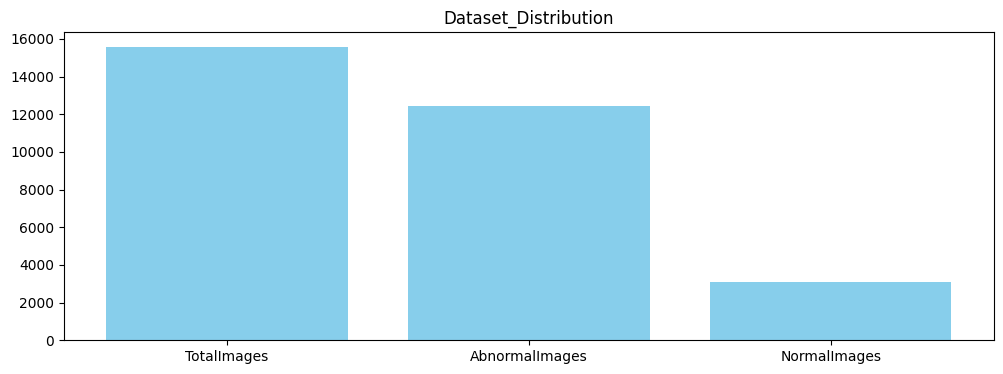

<Figure size 640x480 with 0 Axes>

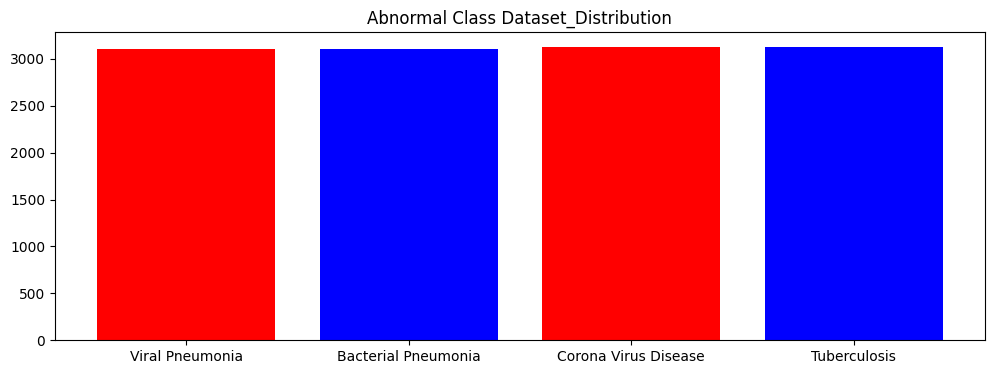

<Figure size 640x480 with 0 Axes>

In [12]:
Main_Object.Visualize_Dataset_Distribution()

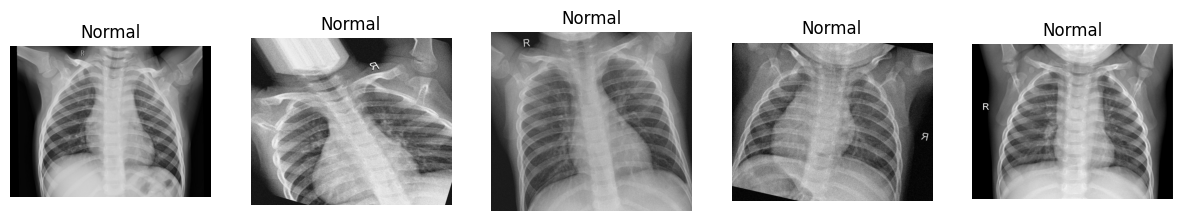

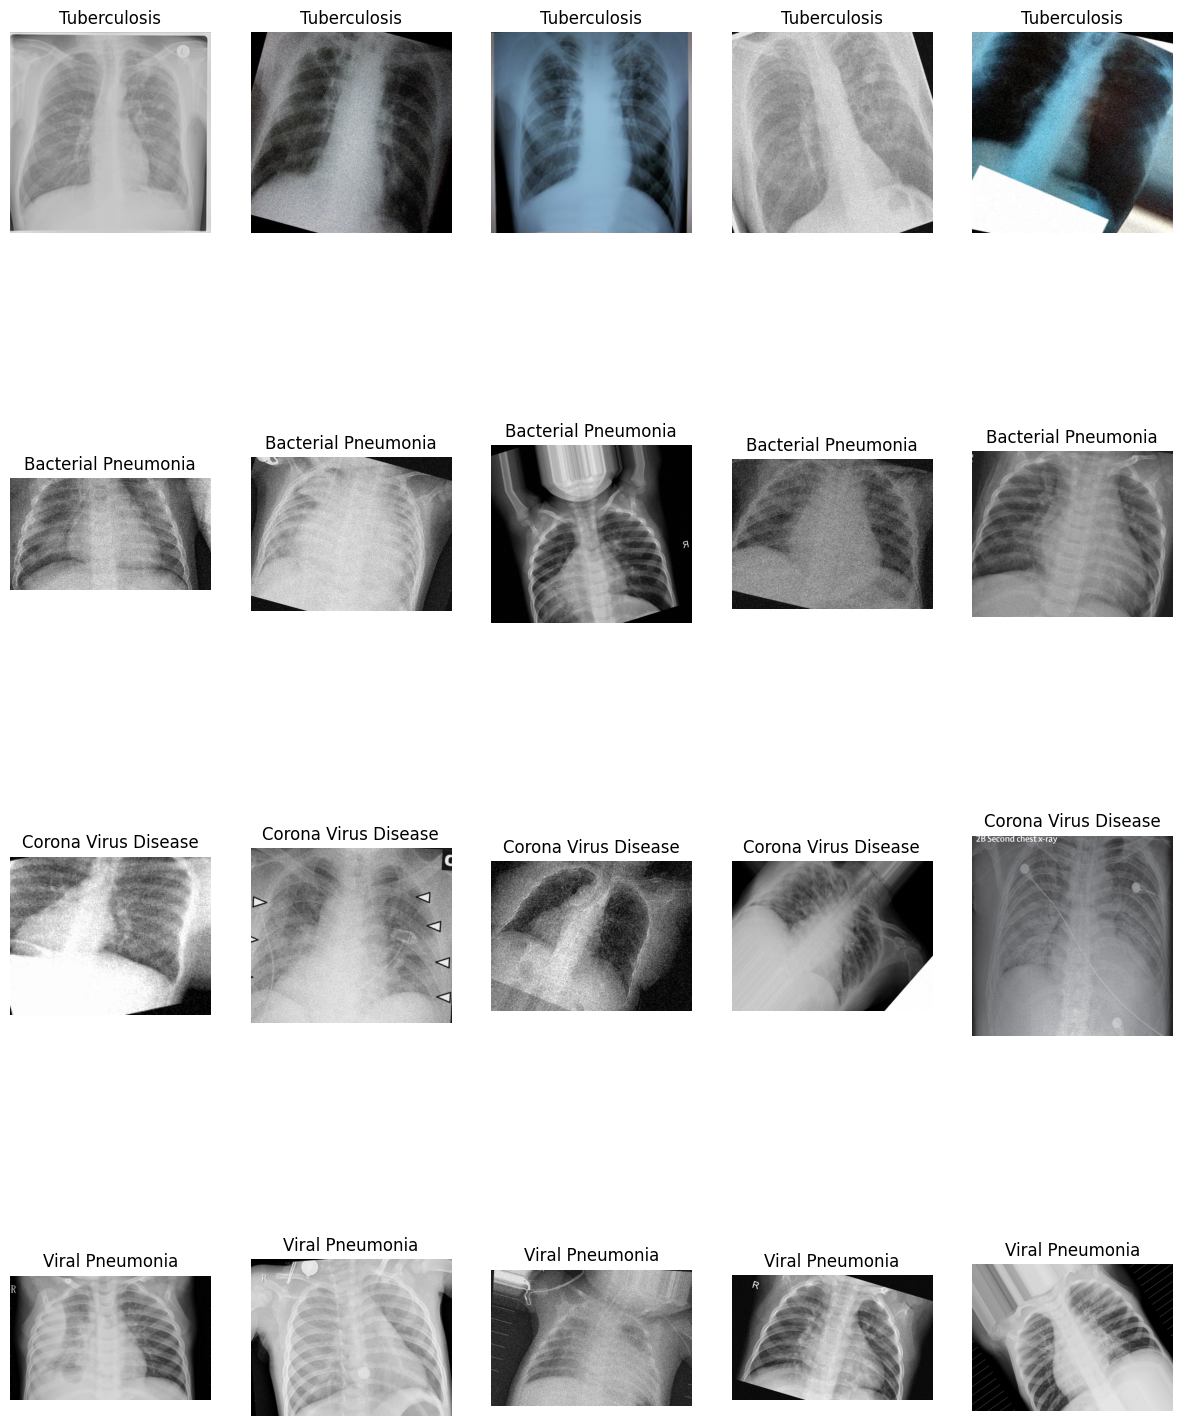

In [12]:
Main_Object.Plot_Samples()

In [13]:
X_train, y_train_binary, y_train_subclass = Main_Object.load_data()
X_train, X_val, y_train_binary, y_val_binary, y_train_subclass, y_val_subclass = train_test_split(
    X_train, y_train_binary, y_train_subclass, test_size=0.2, random_state=42
)

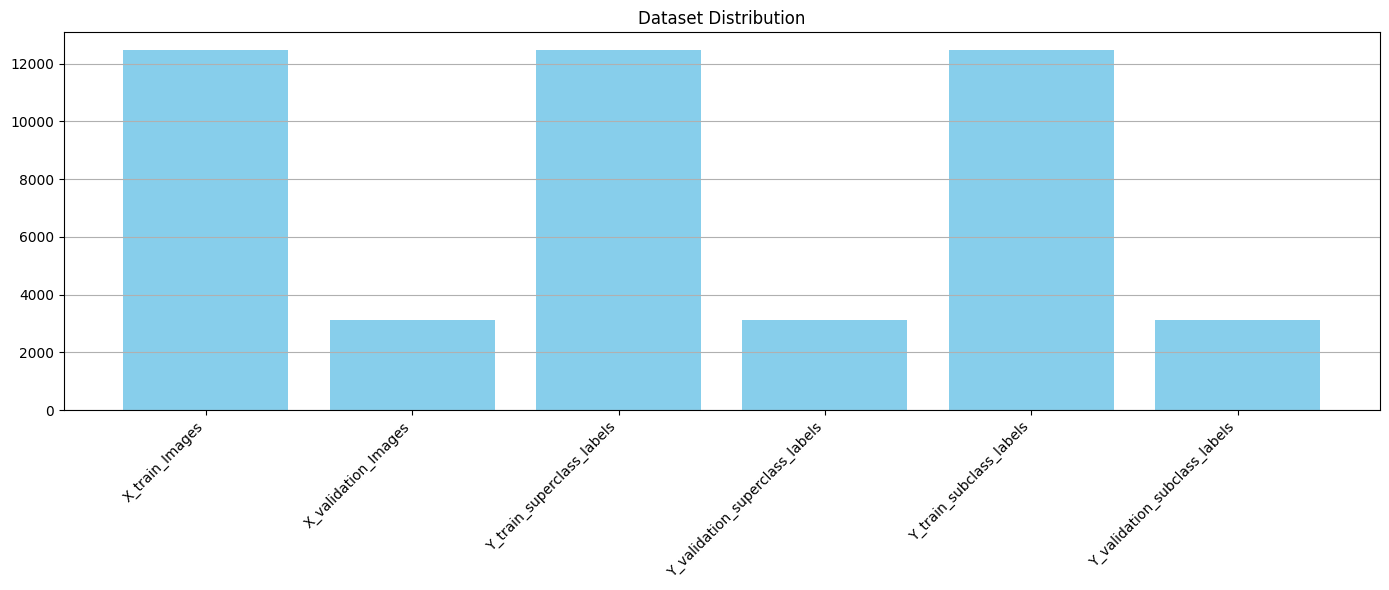

In [21]:
import matplotlib.pyplot as plt

Lengths = [X_train.shape[0], X_val.shape[0], y_train_binary.shape[0], 
           y_val_binary.shape[0], y_train_subclass.shape[0], y_val_subclass.shape[0]]
Labels = ['X_train_Images', "X_validation_Images", "Y_train_superclass_labels", 
          "Y_validation_superclass_labels", "Y_train_subclass_labels", 
          "Y_validation_subclass_labels"]

plt.figure(figsize=(14, 6))  # Increased size for better visibility
plt.title("Dataset Distribution")
plt.bar(Labels, Lengths, color="skyblue")
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.grid(axis='y')  # Add grid lines along the y-axis
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

In [22]:
model = Main_Object.create_hierarchical_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 62, 62,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 31,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 29, 29,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_output       │ (None, 1)         │      9,217 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subclass_output     │ (None, 4)         │     36,868 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,405 (400.02 KB)

 Trainable params: 102,405 (400.02 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history=Main_Object.Model_Training(Model=model
                                   ,X_train=X_train
                                   ,X_val=X_val
                                   ,y_train_binary=y_train_binary
                                   ,y_val_binary=y_val_binary,
                                   y_train_subclass=y_train_subclass
                                   ,y_val_subclass=y_val_subclass)

Epoch 1/100


I0000 00:00:1729804986.287452     878 service.cc:145] XLA service 0x7e283002e120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729804986.287534     878 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 41/390 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_output_accuracy: 0.8449 - loss: 1.7850 - subclass_output_accuracy: 0.3534

I0000 00:00:1729804988.796520     878 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


390/390 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - binary_output_accuracy: 0.8389 - loss: 1.3178 - subclass_output_accuracy: 0.5935 - val_binary_output_accuracy: 0.9030 - val_loss: 0.8479 - val_subclass_output_accuracy: 0.7540
Epoch 2/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_output_accuracy: 0.9036 - loss: 0.7862 - subclass_output_accuracy: 0.7776 - val_binary_output_accuracy: 0.9188 - val_loss: 0.7443 - val_subclass_output_accuracy: 0.7823
Epoch 3/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_output_accuracy: 0.9220 - loss: 0.6773 - subclass_output_accuracy: 0.8013 - val_binary_output_accuracy: 0.9277 - val_loss: 0.7096 - val_subclass_output_accuracy: 0.7861
Epoch 4/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_output_accuracy: 0.9371 - loss: 0.5904 - subclass_output_accuracy: 0.8188 - val_binary_output_accuracy: 0.9242 - val_loss: 0.6911 - val_subclass_output_accuracy: 0.7925
Epoch 5/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_output_accuracy: 0.9454 -

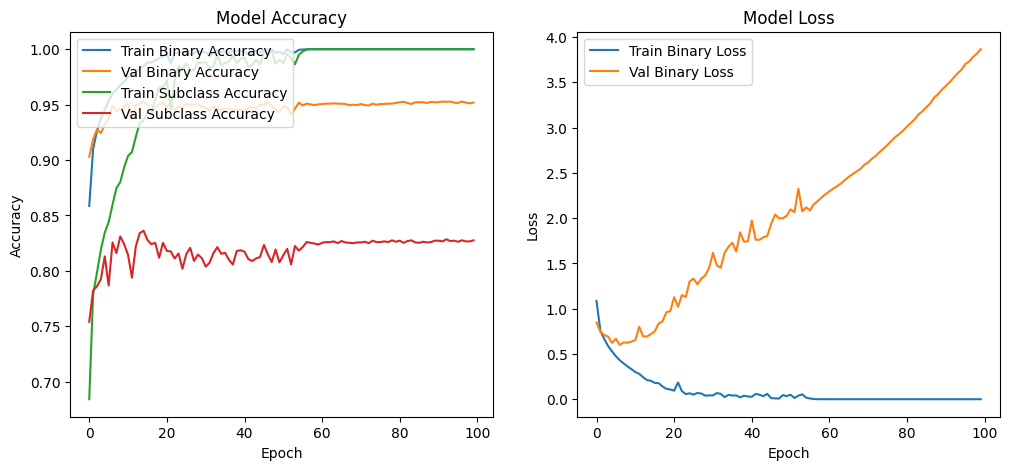

In [27]:

Main_Object.plot_training_history(history)

In [28]:
y_pred_binary, y_pred_subclass = model.predict(X_val)

y_pred_binary = (y_pred_binary > 0.5).astype(int).flatten()

y_pred_subclass = np.argmax(y_pred_subclass, axis=1)

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


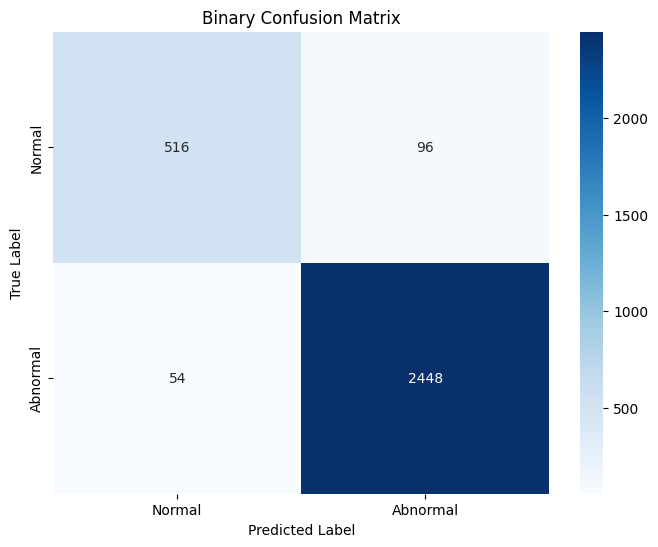

In [29]:
Main_Object.plot_confusion_matrix(y_val_binary=y_val_binary,y_pred_binary=y_pred_binary)

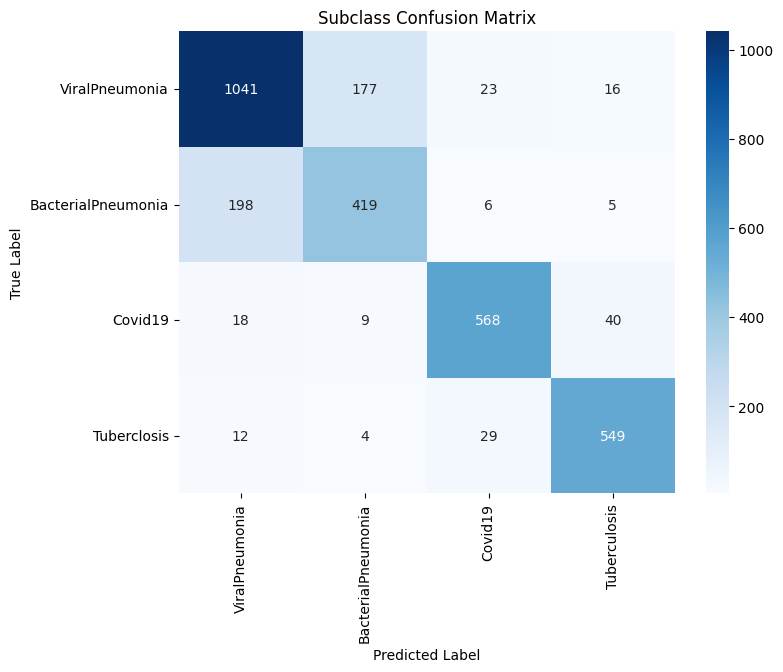

In [40]:
Main_Object.plot_confusion_matrix_subclass(np.argmax(y_val_subclass,axis=1),y_pred_subclass)

In [41]:
Main_Object.Print_Classification_Report(y_pred_binary=y_pred_binary,y_pred_subclass=y_pred_subclass,y_val_subclass=y_val_subclass,y_val_binary=y_val_binary)

Binary Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       612
           1       0.96      0.98      0.97      2502

    accuracy                           0.95      3114
   macro avg       0.93      0.91      0.92      3114
weighted avg       0.95      0.95      0.95      3114

Subclass Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1257
           1       0.69      0.67      0.68       628
           2       0.91      0.89      0.90       635
           3       0.90      0.92      0.91       594

    accuracy                           0.83      3114
   macro avg       0.83      0.83      0.83      3114
weighted avg       0.83      0.83      0.83      3114



In [1]:
from tensorflow import keras

In [2]:
model=keras.models.load_model('model.keras')

In [24]:
path_n="E:\\Project1\\Dataset\\Dataset\\Normal"
path_c="E:\\Project1\\Dataset\\Dataset\\Abnormal\\CoronaVirusDisease"
path_b="E:\\Project1\\Dataset\\Dataset\\Abnormal\\BacterialPneumonia"
path_v="E:\\Project1\\Dataset\\Dataset\\Abnormal\\ViralPneumonia"
path_t="E:\\Project1\\Dataset\\Dataset\\Abnormal\\Tuberculosis"

normal=[]
for images in os.listdir(path_n):
    images_path=os.path.join(path_n,images)
    normal.append(images_path)
normal=normal[:5]

covid=[]
for images in os.listdir(path_c):
    images_path=os.path.join(path_c,images)
    covid.append(images_path)
covid=covid[:5]

bacterial=[]
for images in os.listdir(path_b):
    images_path=os.path.join(path_b,images)
    bacterial.append(images_path)
bacterial=bacterial[:5]

viral=[]
for images in os.listdir(path_v):
    images_path=os.path.join(path_v,images)
    viral.append(images_path)
viral=viral[:5]

tuber=[]
for images in os.listdir(path_t):
    images_path=os.path.join(path_t,images)
    tuber.append(images_path)
tuber=tuber[:5]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


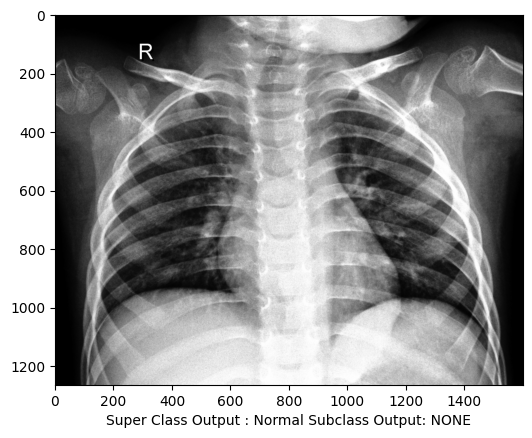

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


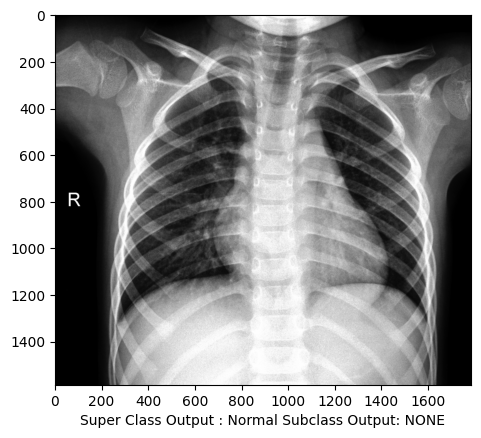

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


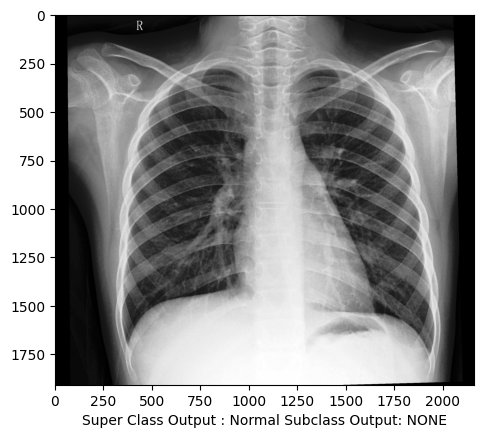

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


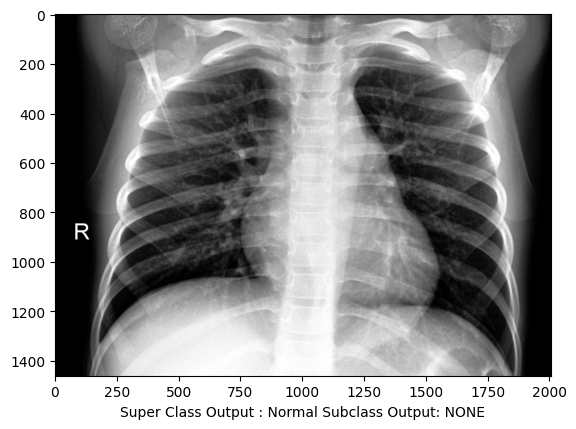

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


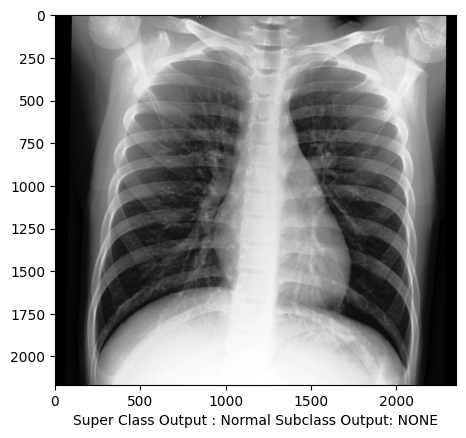

In [27]:
for i in normal: 
   Main_Object.Model_Testing(i,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


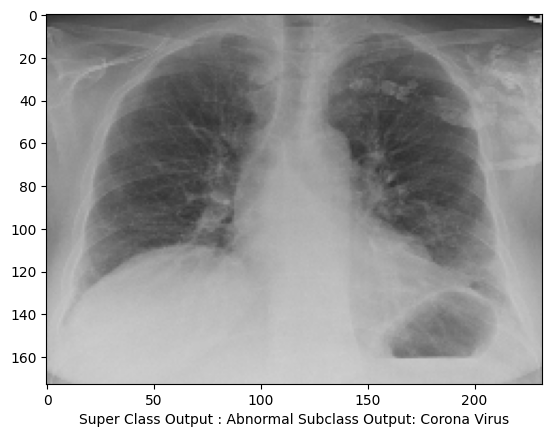

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


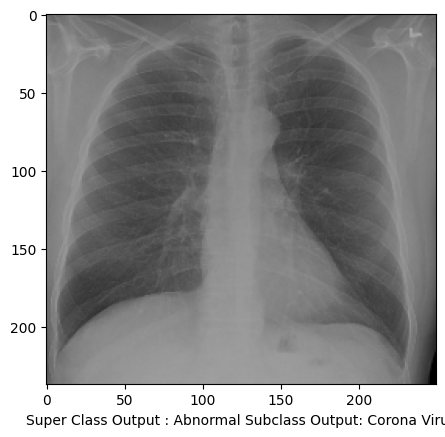

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


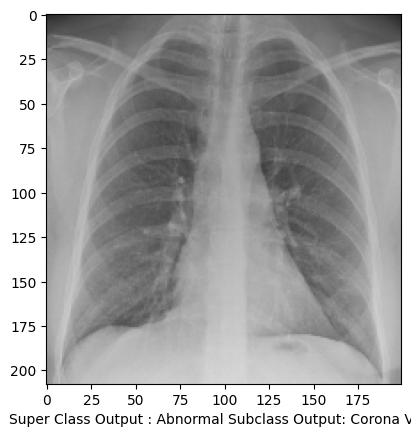

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


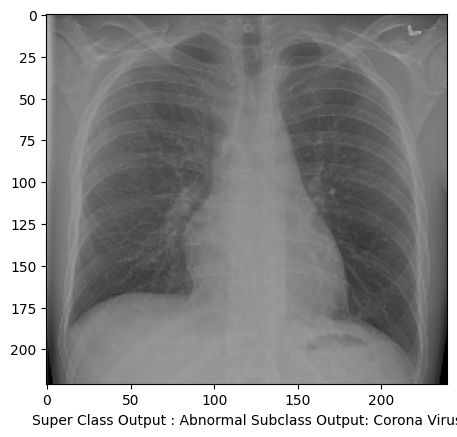

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


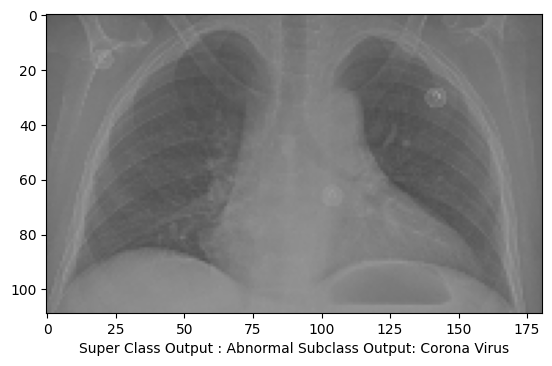

In [26]:
for i in covid: 
   Main_Object.Model_Testing(i,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


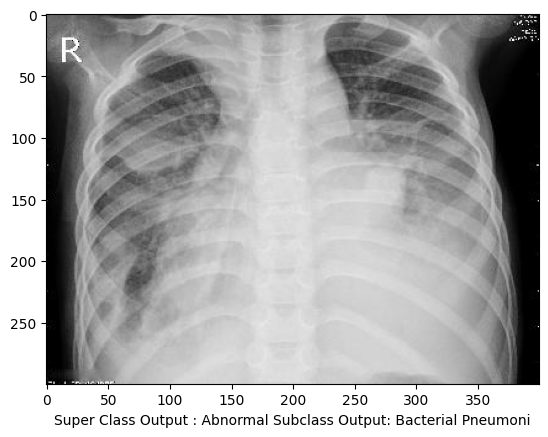

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


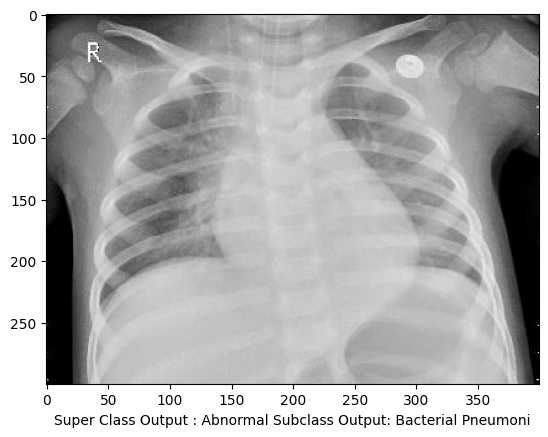

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


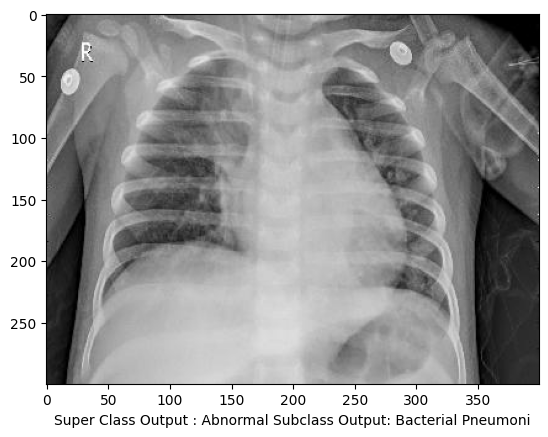

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


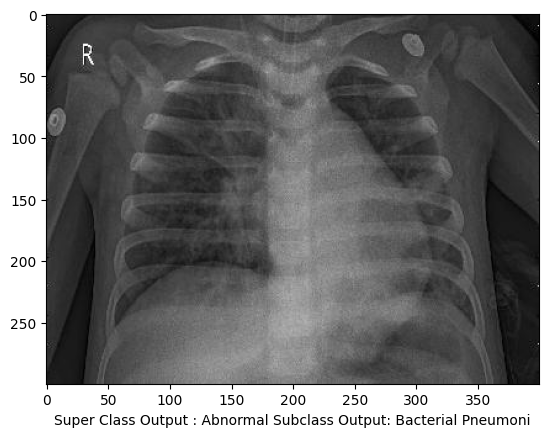

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


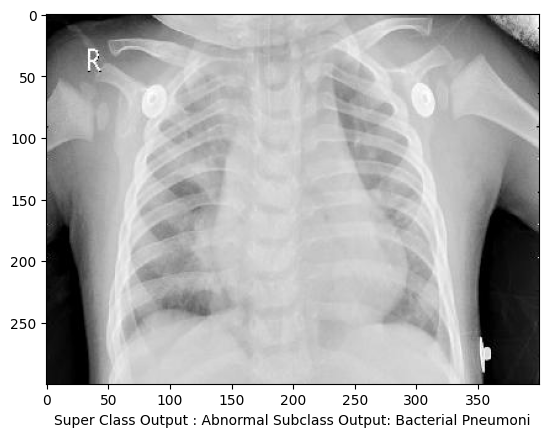

In [28]:
for i in bacterial: 
   Main_Object.Model_Testing(i,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


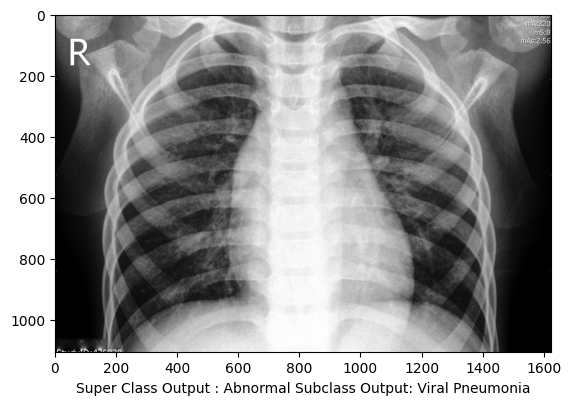

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


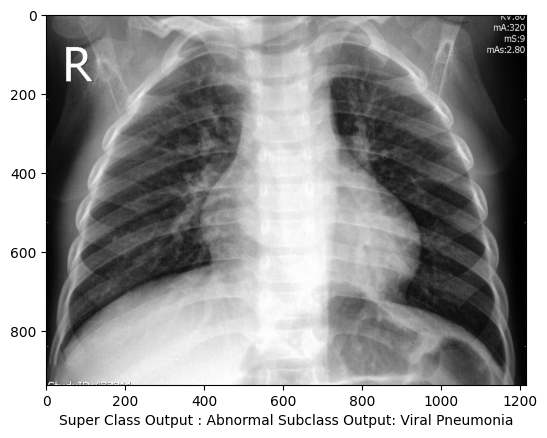

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


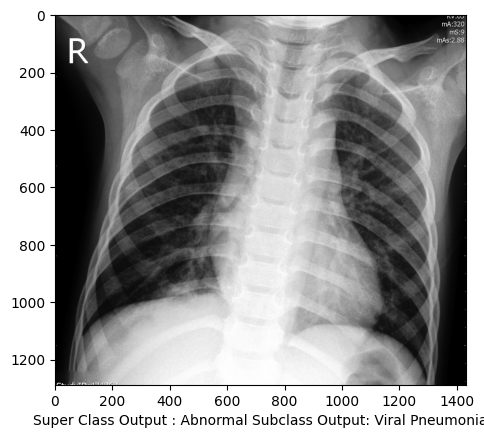

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


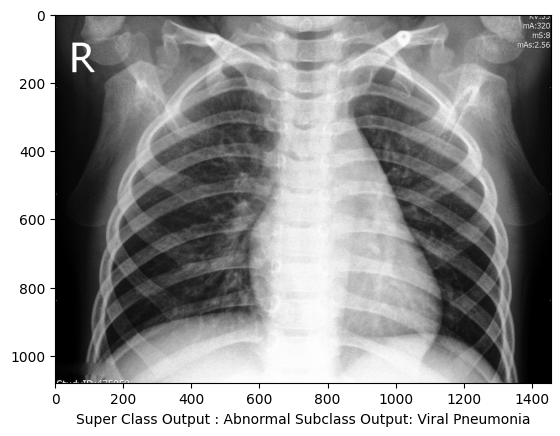

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


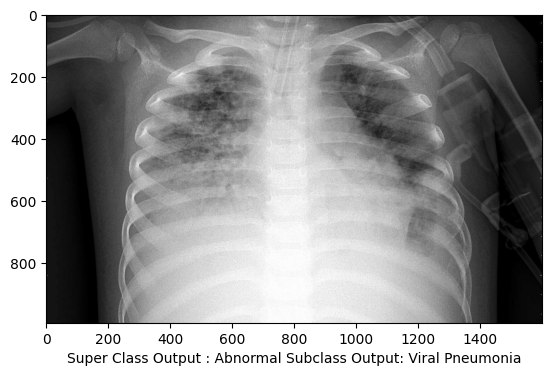

In [29]:
for i in viral: 
   Main_Object.Model_Testing(i,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


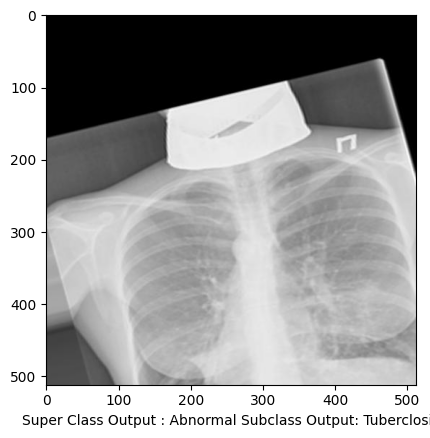

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


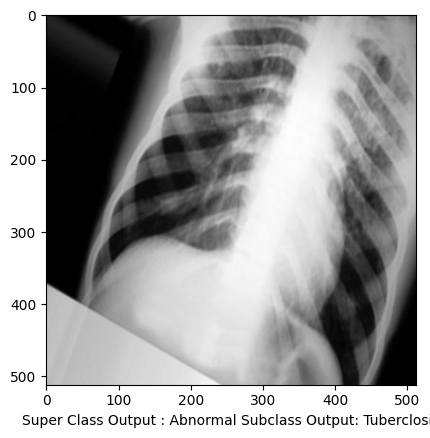

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


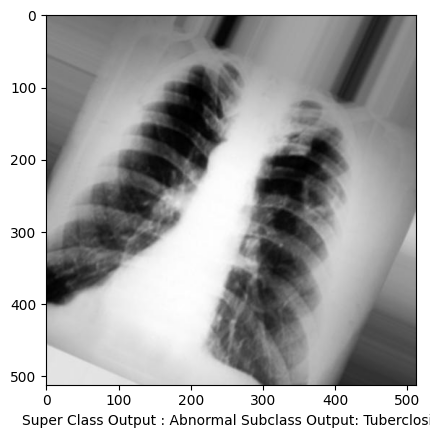

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


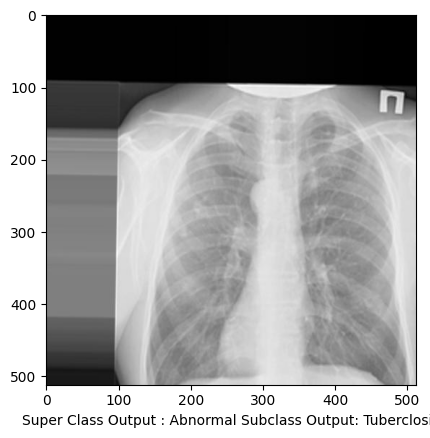

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


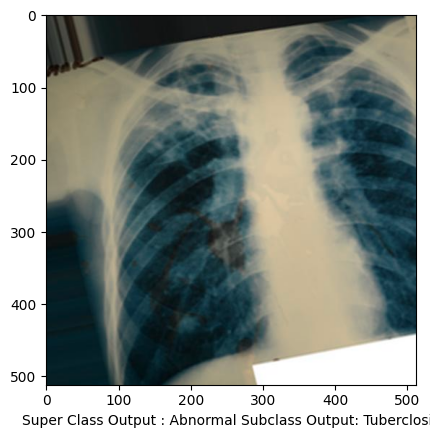

In [30]:
for i in tuber: 
   Main_Object.Model_Testing(i,model)